## DSCI 100 Group Project 

By Tony Fu, Hao Jiang, and Aimee Garcia Castro

## Introduction: 

From the paper of Developing intuitive knowledge classifier and modeling of users' domain-dependent data in web, we can see one of the most powerful technologies for adaptable applications is web-based user modeling. Students' data is used by researchers to personalize topics based on their understanding. The user modeling system's purpose is to ensure that pupils have sufficient or suitable knowledge. (Kahraman et al., 2013)


Many elements play a role in how well a student will perform on a test. The objective of this group project is to predict the knowledge level of an individual based on such elements. We will be looking at the "User Knowledge" dataset obtained from the UCI Machine Learning Repository. The data in this dataset looks at `STG` (study time for main topics), `SCG` (repetition in studying), `STR` (study time for related topics), `LPR` (exam performance of related topics), and `PEG` (exam performance of main topics). All variables from `STG` to `PEG` have a range from 0 to 1. `UNS` contains the labels `very low`, `low`, `middle`, and `high`, where `very low` corresponds to a much lower knowledge level whereas `high` corresponds to a higher knowledge level. 

The predictive question that we will try to answer is: "Can we predict if an individual's `UNS` will be `very low`, `low`, `middle`, or `high` based on factors such as `STG`, `SCG`, `STR`, `LPR`, and `PEG`?"

## Loading and Tidying the Data: 

We begin by loading the libraries required to perform exploratory analysis. We have also used the `set.seed` function to make sure our findings for the classification are reproducible. 

In [1]:
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
library(GGally)
library(readxl)
options(repr.matrix.max.rows = 6)
set.seed(2021)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

We need to transfer the data from the website to R since the data is located on the website. As the data is available as an Excel spreadsheet, we will need to download it as a file with `download.file`. We have stored the file described as an url from the Internet as an object called `url`.

After downloading the data as a file on R, we will use the `read_excel` function to transfer the data from the spreadsheet. We will use `sheet = 2` as the second sheet is listed as **training data** in the spreadsheet, which would be crucial once we create our classifier.

We notice that the last three columns are irrelevant to the data so we will be selecting the wanted data with the `select` function.

Furthermore, although not required, we chose to lowercase all the `UNS` labels to keep the labelling consistent with the `mutate` and `recode` functions.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

user_knowledge <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = recode(UNS, High = 'high', Middle = 'middle', Low = 'low'))

user_knowledge

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 1*: Tidied "User Knowledge" data set obtained from UCI Machine Learning Repository

We can see the data is tidy as each variable is its own column, each observation is in its own row, and each cell has one value.

## Searching for NAs:

We will now be looking for NA values in our data set, and handle them appropriately as they represent a missing value in our data. 

In [3]:
sum(is.na(user_knowledge))

[1] 0

Thankfully there are no NAs in our data frame, so we do not need to make any further adjustments to our data set.

## Choosing Potential Predictors

While looking at potential predictors, we have decided that it seems logical to use all `STG`, `SCG`, `STR`, `LPR`, and `PEG` as predictors. `STG` and `STR` relate to study time on topics. An increase in `STG` and `STR` should result in a higher knowledge level. Similarly, an increase in `SCG` (repetition in studying) should also result in a higher knowledge level as students would have become more familiar with the topics. Finally, `LPR` and `PEG` represent exam performance, which is directly related to knowledge level as a better performance would represent a higher knowledge level. In summary, we believe all the variables have a meaningful relationship with `UNS`, so we kept them all.

Since the categorical class we are predicting is `UNS`, we must turn it into a factor. This is done using the `mutate` and `as_factor` functions.

In [4]:
user_knowledge <- user_knowledge %>%
    mutate(UNS = as.factor(UNS))

user_knowledge

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 2*: Potential predictors with `UNS` changed to class "factor"

We still need to see which predictors we should use and which ones should be removed. We will do this through a method called forward selection, where we build a model by adding one predictor at a time. This model will select the most accurate combinations given the potential predictors `STG`, `SCG`, `STR`, `LPR`, and, `PEG`. 

*Note: The following code was taken from Chapter 6.8 of the textbook.*

In [5]:
names <- colnames(user_knowledge %>% select(-UNS)) 
example_formula <- paste("UNS", "~", paste(names, collapse="+"))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        user_knowledge_recipe <- recipe(as.formula(model_string), 
                                data = user_knowledge) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
        acc <- workflow() %>%
          add_recipe(user_knowledge_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8455479
2,UNS ~ PEG+LPR,0.9498202
3,UNS ~ PEG+LPR+SCG,0.9458202
4,UNS ~ PEG+LPR+SCG+STG,0.8988220
5,UNS ~ PEG+LPR+SCG+STG+STR,0.8140185


*Table 3*: Accuracies of different number of predictors used in the model

The table shows that the most accurate predictor is `PEG`. The second most would be `LPR`, since the model seleceted `PEG` and `LPR` as the most accurate combination when using two predictors. Beforehand, we thought these two would be the best predictors as knowledge level would be directly connected to exam performance compared to study habits. After that, we noticed a gradual decrease in accuracy when we added `SCG`, `STG`, and `STR`. This drop in accuracy signifies that `SCG`, `STG`, and `STR` are more irrelevant predictors than `PEG` and `LPR`. Hence, we will not be using them as predictors. We tried removing `PEG` from the data set to have the model measure the accuracy of the combination of `LPR` with these predictors to validate our decision. Likewise, we removed `LPR` to measure the accuracy of the combination of `PEG` and `SCG`. We found that the original combination of `PEG` and `LPR` resulted in the highest accuracy while looking at two predictors. We will use them in our analysis as we require at least two predictors to create a visualization. Thus, we can remove `SCG`, `STG`, and `STR` from our data frame.

In [6]:
user_knowledge <- user_knowledge %>%
    select(-SCG, -STG, -STR)

user_knowledge

LPR,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.24,0.90,high
0.25,0.33,low
⋮,⋮,⋮
0.29,0.77,high
0.61,0.26,middle
0.87,0.74,high


*Table 4*: Predictors that will be used for analysis

Therefore, the predictors we will use are `PEG` and `LPR` with `UNS` being the categorical class we are predicting.

## Summarizing the Data Set:

To start, we will summarize the data set to obtain statistics which will be used for the data analysis section.  

First, we will create some plots with our predictors `PEG` and `LPR` and see their relationship with our categorical variable of interest `UNS`. Since `UNS` has different levels, we will create boxplots showing the relationship between `PEG` and `LPR`, and each level of `UNS`. We will be reordering the boxplots in terms of ascending order of medians.

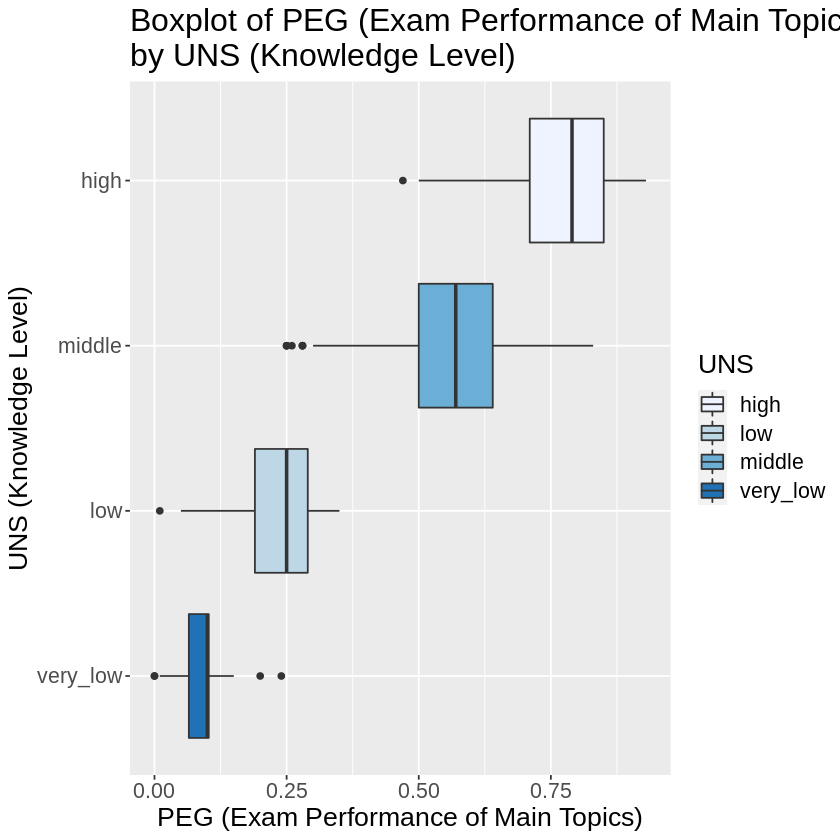

In [7]:
user_knowledge_plot <- ggplot(user_knowledge, aes(x = PEG, y = reorder(UNS, +PEG, median), fill = UNS)) +
    geom_boxplot() +
    labs(x = "PEG (Exam Performance of Main Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of PEG (Exam Performance of Main Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot

*Figure 1*: Boxplot of `PEG` by `UNS`

Based on *Figure 1*, we can see that `very_low` has the lowest `PEG` median, `low` has the second lowest, `middle` has the second highest, and `high` has the highest. We can conclude that as `PEG` increases, so does the `UNS` as seen with the medians of each boxplot. This indicates that there is a positive relationship between `PEG` and the different levels of `UNS` based on the medians. The relationship is also strong as the medians differ greatly across the different levels. Hence, `PEG` does affect the levels of `UNS`, and impacts them greatly. This will be discussed in our data analysis section.

We can make similar boxplots showing the relationship between `LPR` and each level of `UNS`.

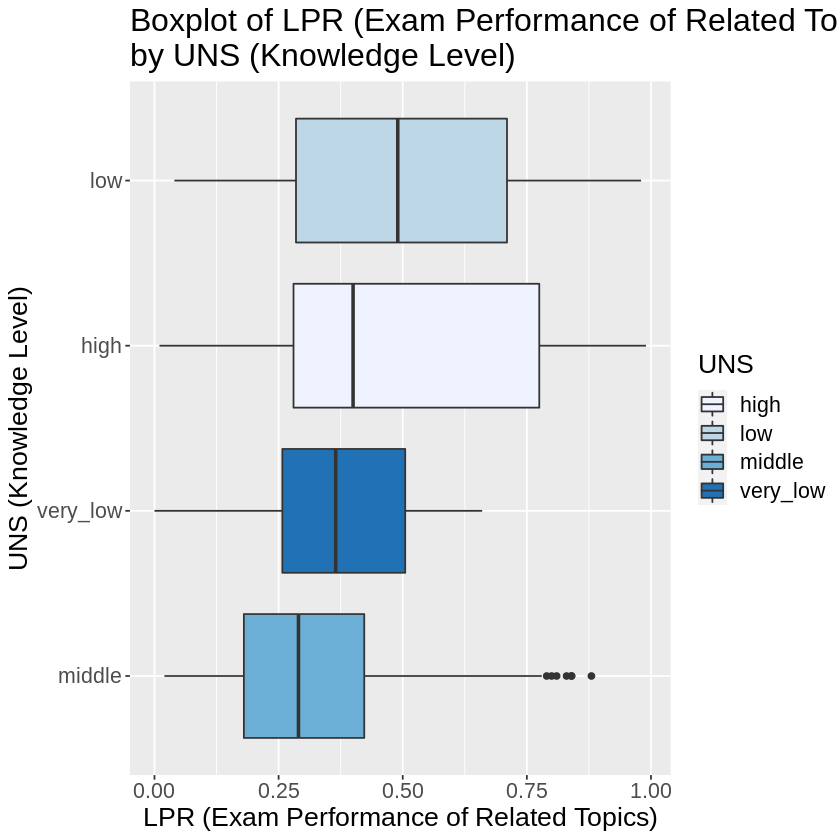

In [8]:
user_knowledge_plot_2 <- ggplot(user_knowledge, aes(x = LPR, y = reorder(UNS, +LPR, median), fill = UNS)) +
    geom_boxplot() +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of LPR (Exam Performance of Related Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot_2

*Figure 2*: Boxplot of `LPR` by `UNS`

Looking at *Figure 2*, we can see that `middle` has the lowest `LPR` median, `very_low` has the second lowest `LPR` median, `high` has the second highest `LPR` median, and `low` has the highest `LPR` median. We can see that there is no clear relationship between `LPR` and the different levels of `UNS`. Although, it is hard to come to this conclusion solely looking at the medians. For now, we will consider that there is no relationship but we will further investigate this relationship in the data analysis section

Next, we will calculate the mean, median, and standard deviation of both `PEG` and `LPR` in the data set.

In [9]:
peg_stats <- user_knowledge %>%
    summarize(mean_peg = mean(PEG),
              med_peg = median(PEG), 
              sd_peg = sd(PEG))

peg_stats

mean_peg,med_peg,sd_peg
<dbl>,<dbl>,<dbl>
0.4585388,0.5,0.2552109


*Table 5*: Mean, median, and standard deviation of `PEG`

Here, the `PEG` mean is around 0.46. The `PEG` median is 0.5, and the standard deviation is around 0.26.

In [10]:
lpr_stats <- user_knowledge %>%
    summarize(mean_lpr = mean(LPR),
              med_lpr = median(LPR), 
              sd_lpr = sd(LPR))

lpr_stats

mean_lpr,med_lpr,sd_lpr
<dbl>,<dbl>,<dbl>
0.4327132,0.33,0.248108


*Table 6*: Mean, median, and standard deviation of `LPR`

On the other hand, the `LPR` mean is around 0.43. The `LPR` median is 0.33, and the standard deviation is around 0.25.

Next, we found the number and percentage of the levels of `UNS` in our data set with the `group_by` and `summarize` functions. This will let us see if one label is more frequent compared to others.

In [11]:
UNS_proportions <- user_knowledge %>%
    group_by(UNS) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(user_knowledge))

UNS_proportions

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n,percent
<fct>,<int>,<dbl>
high,63,24.418605
low,83,32.170543
middle,88,34.108527
very_low,24,9.302326


*Table 7*: Proportions of each UNS level 

For our training data, we have 63 (24%) highs, 88 (34%) middles, 83 (32%) lows and 24 (9%) very lows in our data set regarding levels of `UNS`. We can see that there are more `middle` and `low` labels compared to `high` labels, and much more compared to `very low` labels.

We can also find the range of `PEG` and `LPR` in our data set.

In [13]:
peg_range_overall <- range(user_knowledge$PEG)

peg_range_overall

[1] 0.00 0.93

The lowest `PEG` value observed is 0 and the largest observed is 0.93.

In [14]:
lpr_range <- range(user_knowledge$LPR)

lpr_range

[1] 0.00 0.99

The lowest `LPR` value observed is 0 while the largest observed is 0.99.

## Building the Classifier

Firstly, we need to create a recipe to preprocess our unscaled data. By doing so, our predictors will be scaled and centered.

In [15]:
set.seed(2022)

user_knowledge_recipe <- recipe(UNS ~ PEG + LPR, data = user_knowledge) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

user_knowledge_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Now, we will try to find the optimal value of K to use in our classifier by performing a 10-fold cross-validation on our training data. We use the `vfold_cv` function along with the data set, the number of folds (v), and the strata arguments. The strata argument contains our categorical variable `UNS`.  

In [16]:
user_knowledge_vfold <- vfold_cv(user_knowledge, v = 10, strata = UNS)
print(user_knowledge_vfold)

#  10-fold cross-validation using stratification 
# A tibble: 10 x 2
   splits           id    
   <list>           <chr> 
 1 <split [231/27]> Fold01
 2 <split [232/26]> Fold02
 3 <split [232/26]> Fold03
 4 <split [232/26]> Fold04
 5 <split [232/26]> Fold05
 6 <split [232/26]> Fold06
 7 <split [232/26]> Fold07
 8 <split [233/25]> Fold08
 9 <split [233/25]> Fold09
10 <split [233/25]> Fold10


Now, we will build our tune model. Since we want to do a classification, we will specify the engineer as `kknn` and the mode as `classification`. We will also use `tune()` in the neighbors argument since we have not yet chosen a K value. 

In [17]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we will perform cross-validation across the folds with our prepared recipe and tune model. We will make a data frame called `k_vals` that contains K values from 1 to 100, incrementing by 5. `k_vals` will be used in the `tune_grid` function. Then, `collect_metrics` is used to collect the cross-validation results. Finally, we will filter `.metric` by accuracy to obtain the accuracy for each potential K value.

In [31]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

user_knowledge_results <- workflow() %>%
    add_recipe(user_knowledge_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = user_knowledge_vfold, grid = k_vals) %>%
    collect_metrics()%>% 
    filter(.metric == "accuracy") 

user_knowledge_results

! Fold06: internal: No observations were detected in `truth` for level(s): 'very_l...

! Fold08: internal: No observations were detected in `truth` for level(s): 'very_l...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9498234,10,0.012882907,Model01
2,accuracy,multiclass,0.9498234,10,0.012882907,Model02
3,accuracy,multiclass,0.9536809,10,0.009583024,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.8382621,10,0.03691296,Model48
49,accuracy,multiclass,0.8344160,10,0.03746315,Model49
50,accuracy,multiclass,0.8305698,10,0.04006852,Model50


*Table 8*: Results from 10-fold cross validation

With the table above, we can create a plot using the number of neighbors on the x-axis and the accuracy estimate on the y-axis to choose the best K value for our classifier.

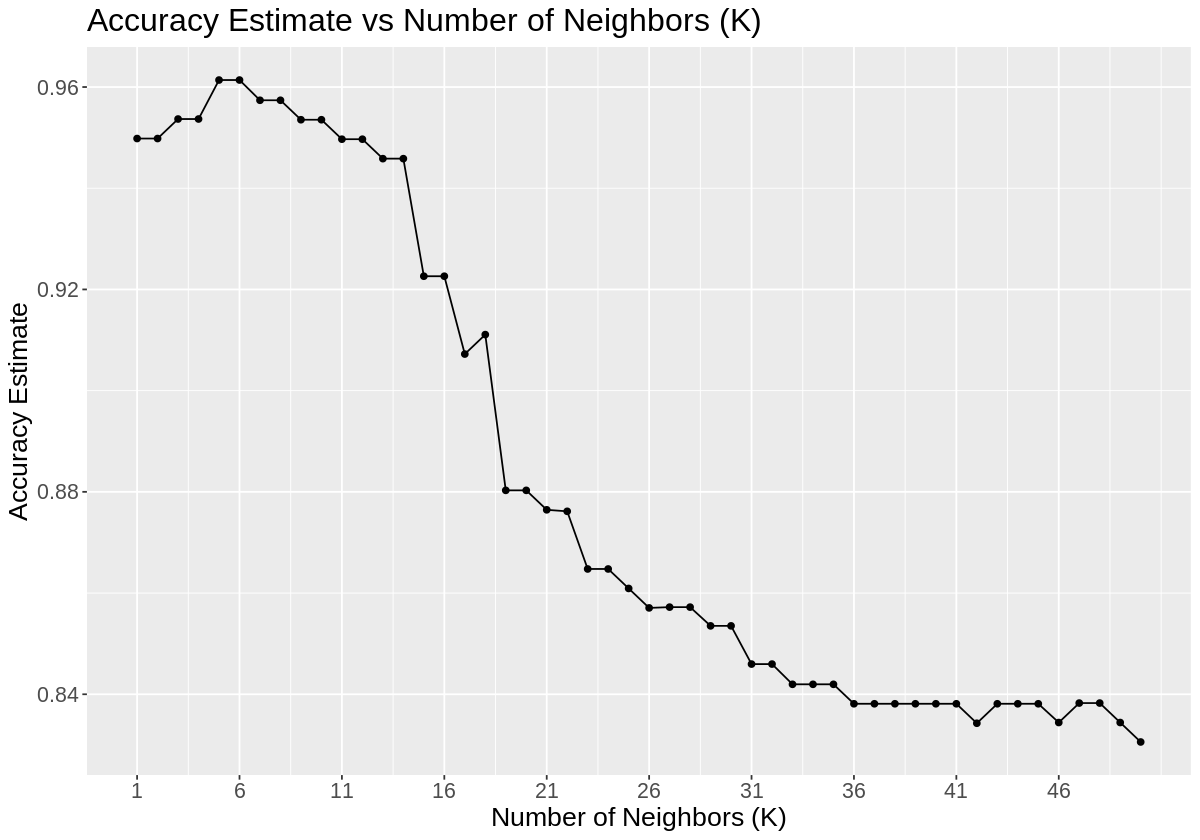

In [32]:
options(repr.plot.width = 10, repr.plot.height = 7)

accuracy_versus_k <- ggplot(user_knowledge_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors (K)", y = "Accuracy Estimate") +
    ggtitle("Accuracy Estimate vs Number of Neighbors (K)") +
    theme(text = element_text(size = 16)) +
    scale_x_continuous(breaks = seq(1, 50, by = 5))

accuracy_versus_k

*Figure 3*: Plot of accuracy estimate vs number of neighbors

We take the K with the highest accuracy estimate to use in the classifier. In this case, any value between 1 to 11 would be acceptable as they have the highest accuracy estimate. Looking at the graph, we can see that it peaks at K = 6. Thus, we have decided to use K = 5 as our K value should be an odd number to avoid ties. It has one of the highest accuracy estimate relative to other points and it is a low K value. We will remake our model using K = 5.

In [20]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
          set_engine("kknn") %>%
          set_mode("classification")

knn_spec_2

user_knowledge_fit <- workflow() %>%
                      add_recipe(user_knowledge_recipe) %>%
                      add_model(knn_spec_2) %>%
                      fit(data = user_knowledge)

user_knowledge_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04263566
Best kernel: rectangular
Best k: 5

To evaluate the estimated accuracy of our classifier on the test set, we use the `predict` and `bind_cols` functions. We can compare the .pred_class column (which contains the predictions from our classifier) with the `UNS` column (which contains the true values).

In [21]:
user_knowledge_test <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 3) %>%
    select(LPR, PEG, UNS) %>%
    mutate(UNS = gsub(" ", "", UNS)) %>%
    mutate(UNS = recode(UNS, High = "high", Middle = "middle", Low = "low", VeryLow = "very_low")) %>%
    mutate(UNS = as.factor(UNS))

user_knowledge_test_predictions <- predict(user_knowledge_fit, user_knowledge_test) %>%
                                   bind_cols(user_knowledge_test)

user_knowledge_test_predictions

New names:
* `` -> ...7
* `` -> ...8



.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
very_low,0.26,0.05,very_low
low,0.60,0.14,low
high,0.60,0.85,high
⋮,⋮,⋮,⋮
low,0.13,0.32,low
middle,0.57,0.57,middle
middle,0.97,0.24,middle


*Table 9*: Testing data with our classifier's predictions added

To get statistics about the quality of our model, we will use the `metrics` function and filter `.metrics` by accuracy to see the accuracy estimate.

In [22]:
user_knowledge_prediction_accuracy <- user_knowledge_test_predictions %>%
                metrics(truth = UNS, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

user_knowledge_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9724138


*Table 10*: The metrics of classifier's predictions on the testing data

The estimated accuracy of our classifier on the testing data is around 97% accurate. We will look at the confusion matrix to see the correct and incorrect predictions made by our classifier.

In [23]:
user_knowledge_mat <- user_knowledge_test_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)

user_knowledge_mat

          Truth
Prediction high low middle very_low
  high       39   0      0        0
  low         0  45      1        2
  middle      0   1     33        0
  very_low    0   0      0       24

*Table 11*: Confusion matrix showing correct and incorrect predictions

Our classifier predicted `high` correctly 39 times and incorrectly 0 times. It predicted `middle` correctly 33 times and incorrectly 1 times. It predicted `low` correctly 45 times and incorrectly 1 times. It also predicted `very_low` correctly 24 time and incorrectly 2 times. 

To test some made-up observations, we will create some tibbles and predict their `UNS` with our classifier. The first tibble we have created represents an average student, using the mean `PEG` and `LPR` value we calculated in the "Summarizing the Data Set" section.

In [24]:
first_observation <- tibble(PEG = 0.46, LPR = 0.43)

first_prediction <- predict(user_knowledge_fit, first_observation)

first_prediction

.pred_class
<fct>
middle


The classifier predicted that this observation would be labelled as `middle`. This is rather accurate as we would expect an average student would be predicted as either a `low` or `middle` level, which would be considered as an average level. 

We will do another test observation of an academically strong student with 90% of the largest STG and STR that we found in the "Summarizing the Data Set" section.

In [25]:
second_observation <- tibble(PEG = 0.9 * 0.93, LPR = 0.9 * 0.99)

second_prediction <- predict(user_knowledge_fit, second_observation)

second_prediction

.pred_class
<fct>
high


The classifier predicted that this observation would also be labelled as `high`. In this case, `high` is an appropriate prediction as a student who has a relatively high `PEG` and `LPR` has a higher knowledge level.

Now, we will be visualizing our data by creating a graph, which has `LPR` on the x-axis, `PEG` on the y-axis, and colours each point based on `UNS`. Then, we will also add our hypothetical data points on the graph.

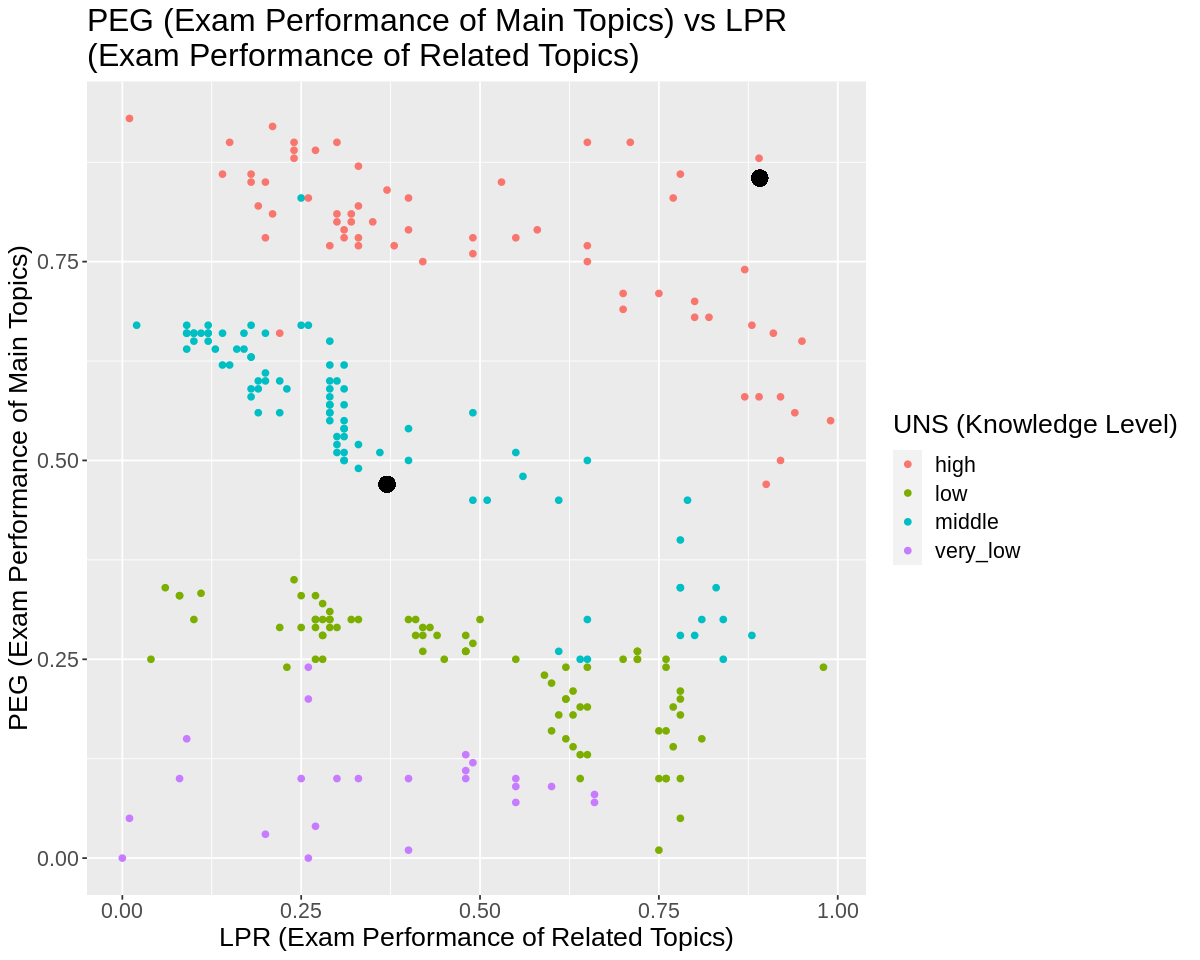

In [26]:
options(repr.plot.width = 10, repr.plot.height = 8)

user_knowledge_graph <- user_knowledge %>%
    ggplot(aes(x = LPR, y = PEG, color = UNS)) + 
    geom_point() + 
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") + 
    theme(text = element_text(size = 16)) +
    geom_point(aes(x = 0.37, y = 0.47), color = "black", size = 4) + 
    geom_point(aes(x = 0.9 * 0.99, y = 0.9 * 0.95), color = "black", size = 4) 
    

user_knowledge_graph

*Figure 4*: Plot of `PEG` vs `LPR` colored by `UNS` with the additional created observations

We can see that the point representing an average student is relatively close to an observations with `UNS` level of `middle`. It seems like a clear consensus that the average student also be labelled as `middle` based on these known observations. Similarly, the point representing an academically strong student is mainly close to points with the `UNS` level of `high`. Again, it is a clear consensus that this student will be labelled as `high`. We will discuss more about this in the following sections.

## Data Analysis

Next, we can create another graph visualizing our predictions to see if there are any interesting patterns.

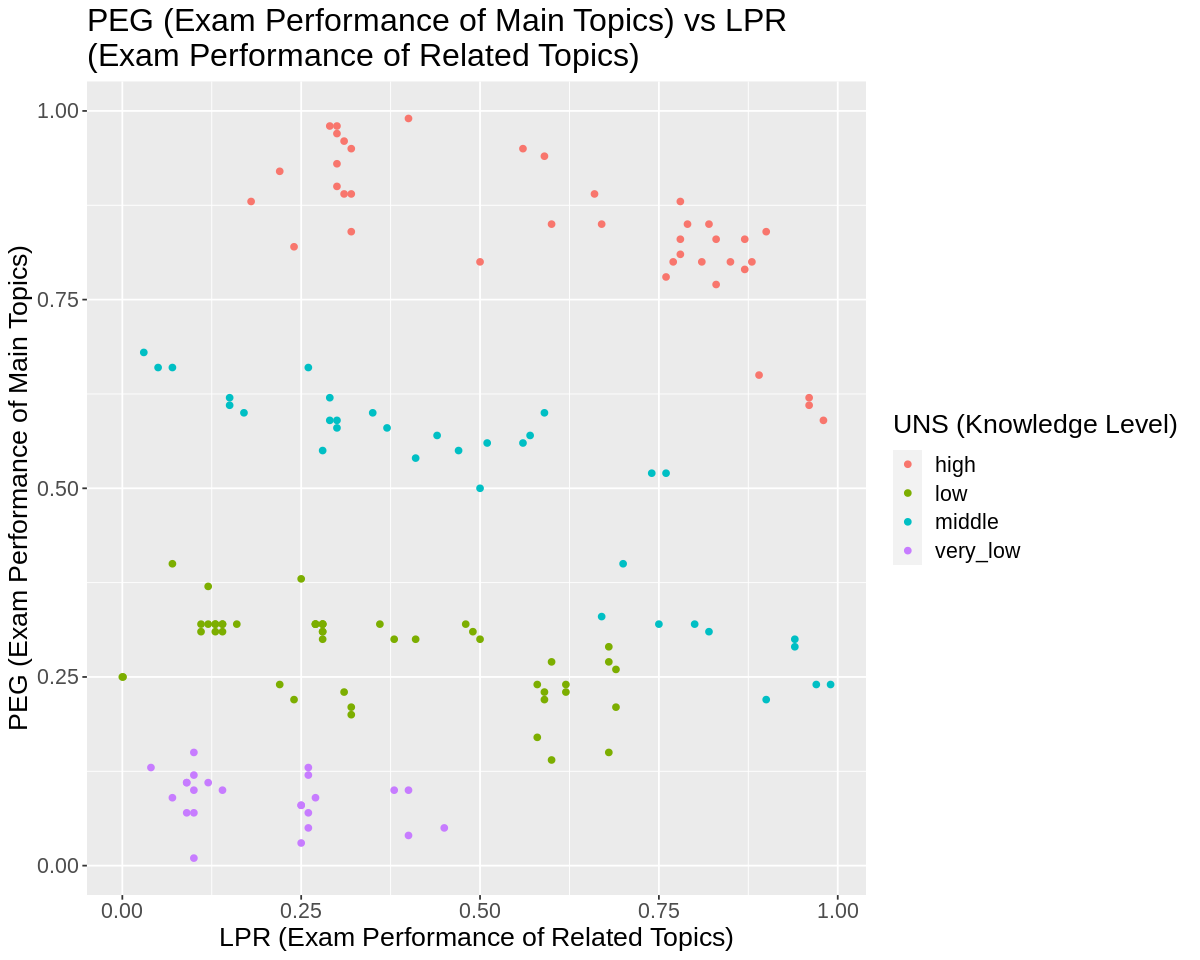

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)

predictions_graph <- user_knowledge_test_predictions %>%
    ggplot(aes(x = LPR, y = PEG, color = .pred_class)) +
    geom_point() +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") +
    theme(text = element_text(size = 16)) 

predictions_graph

*Figure 5*: Plot of `PEG` vs `LPR` coloured by `UNS` based on predicting the testing data

On first glance, we can see that the different levels of `UNS` are grouped well together. From top to bottom, it goes from `high`, to `middle`, to `low`, to `very low`. Comparing *Figure 4* to *Figure 5*, we can also see that the placement of the points are relatively similar. If we overlap the two figures, then the points would align up according to `UNS` level.

To help with our data analysis, we will make a plot similar to *Figure 4*. However, this graph will additionally colour the background based on the decision of our classifier. 

*Note: The following code was taken from Chapter 5.8 of the textbook.*

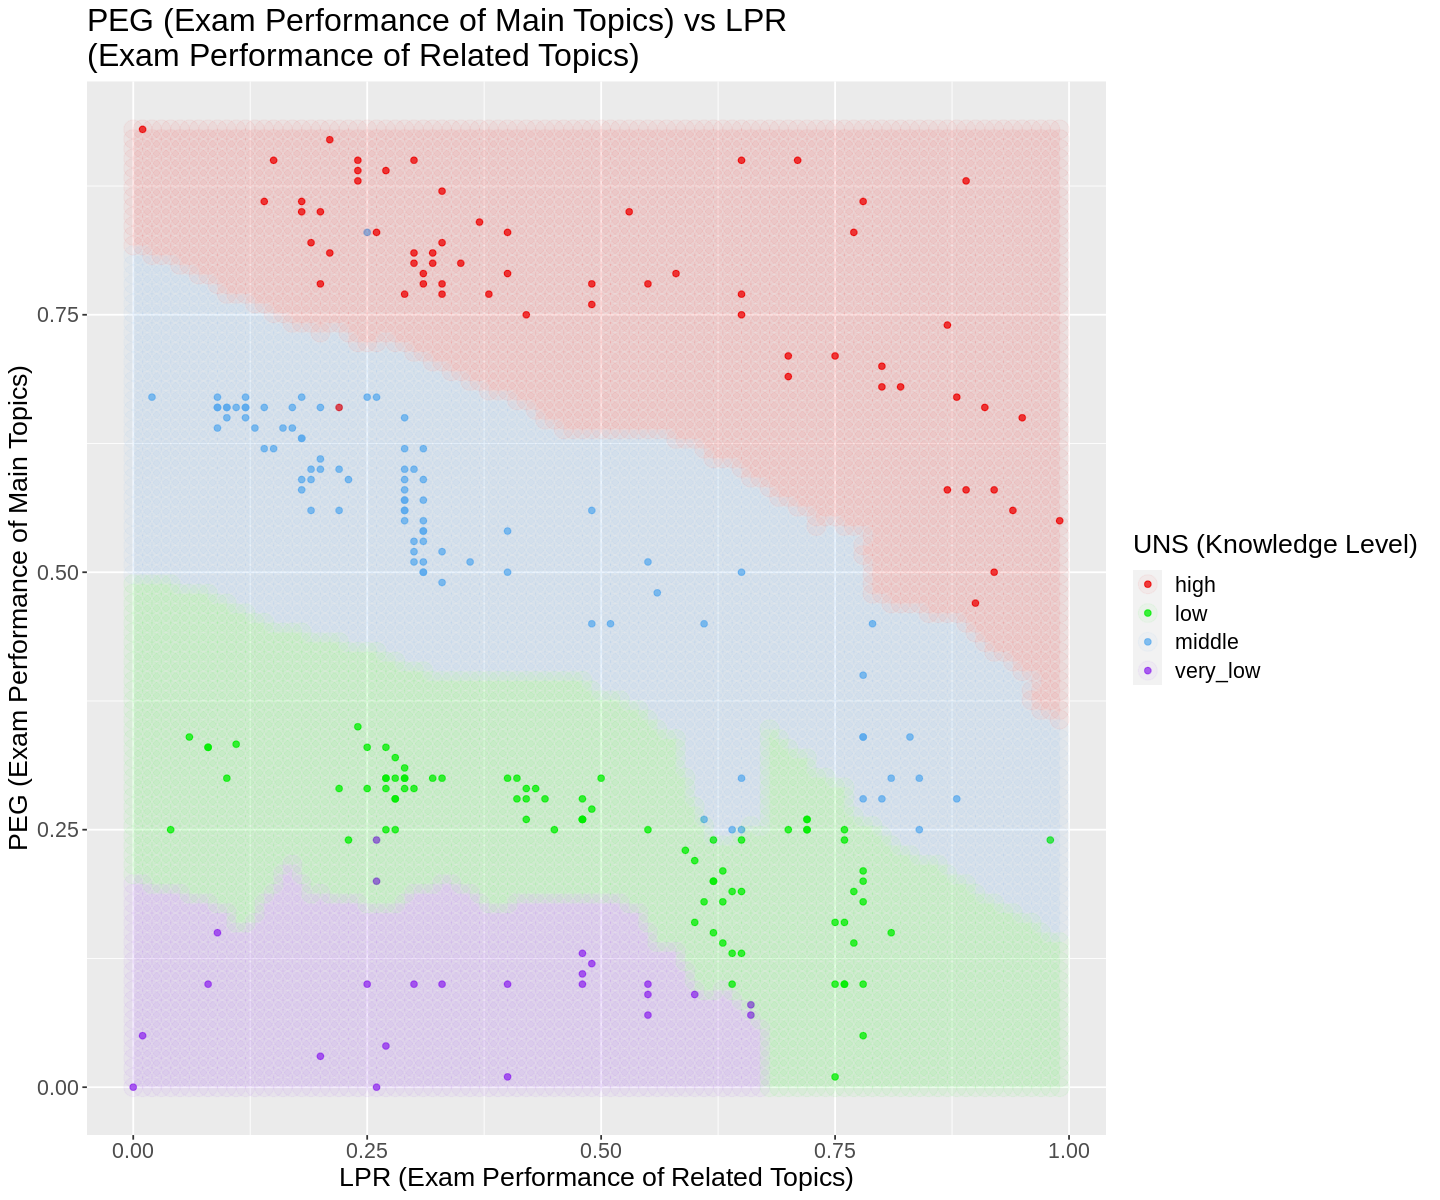

In [28]:
options(repr.plot.width = 12, repr.plot.height = 10)

are_grid <- seq(min(user_knowledge$LPR), 
                max(user_knowledge$LPR), 
                length.out = 100)

smo_grid <- seq(min(user_knowledge$PEG), 
                max(user_knowledge$PEG), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

knnPredGrid <- predict(user_knowledge_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
  rename(UNS = .pred_class)

user_knowledge_graph_2 <- ggplot() +
    geom_point(data = user_knowledge, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.75) +
    geom_point(data = prediction_table, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.04, 
               size = 5) +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") +
    scale_color_manual(labels = c("high", "low", "middle", "very_low"), 
                       values = c("red2", "green2", "steelblue2", "purple2")) +
    theme(text = element_text(size = 16))

user_knowledge_graph_2

*Figure 6*: Plot of `PEG` vs `LPR` where background colour represents the decision of our classifier

From our statistics we obtained in "Summarizing the Data Set", we noted that there was a strong positive relationship between `PEG` and `UNS`. We can clearly see this in the graph as when `PEG` increases, the `UNS` level tends to increase in response. Furthermore, we hypothesized that there was no clear relationship between `LPR` and `UNS`, since `middle` had the lowest `LPR` median and `low` had the highest. In this graph, there does not seem to be relationship as we can see at many `LPR` value, there are points at that value with differing `UNS` levels. This also explains why our `LPR` boxplots' interquartile ranges have a larger range than the `PEG` boxplots as every `UNS` level has a large range of `LPR` values. 

We also calculated that the `PEG` mean is around 0.46 and the median is 0.5, indicating that there is a relatively symmetrical distrbution of `PEG` values. We also found that the range of `PEG` is between 0 to 0.93. This is reflective of the graph as we can see the graph divides into four areas (representing the different `UNS` levels) with similar ranges at low `LPR` values by looking at the background colour. `very low` has a `PEG` range from 0 to around 0.20. `low` has a range from around 0.20 to around 0.50. `middle` has a range from around 0.50 to around 0.80. `high` has a range from around 0.80 to 0.93. Furthermore, we also see that the `PEG` value separating `low` from `high` is around 0.58, which closely matches our mean `PEG`. As a result, we can say that the ranges of `PEG` values for each `UNS` level are relatively equal when there is low `LPR`.

On the other hand, the `LPR` mean is around 0.43 and the median is 0.33, which shows a large difference, indicating that there are more data points with a lower `LPR` value than higher ones. We also found that the range of `LPR` is between 0 to 0.99. This is also reflective of the graph as for `very low` the `LPR` range is between 0 to around 0.65, and the rest of the levels have a range from 0 to 0.99 looking at background colour. Specifically, looking at the colour of the data points, we can that the `LPR` value for `low` levels does not exceed 0.80, and for `middle` levels, it does not exceed 0.90. We can see as `LPR` increases, the `PEG` value can be less than the ranges mentioned above, but still have the same `UNS` level. For example, `very low` does not have a large range of `LPR` values and thus, the range of `PEG` values is rather consistent. However, for `high`, we can see that at the highest value of `LPR`, the `PEG` value is around 0.30. This is a great difference compared to the range of `PEG` values established at the start. This makes sense as we can expect if students have a larger `LPR` value, they can sacrifice some of their `PEG` value and still obtain the same `UNS` level as students with a large `PEG` value but rather low `LPR` value. 

## Discussion

The accuracy of our model is around 97%, which is incredibly high. An accuracy this high would be sufficient for predicting something like knowledge level, which would not lead to detrimental consequences if there are wrong predictions. Thus, our model could be used for real life applications. 

In *Figure 6*, we established that there is a strong relationship between `PEG` and `UNS`, where an increase in `PEG` results in an increase in `UNS`. Furthermore, there is also no clear relationship between `LPR` and `UNS`, meaning that `PEG` influences `UNS` more than `LPR`. For each level of `UNS` when there is low values of `LPR`, the range of `PEG` values are relatively similar. Although, as `LPR` increases, we can see that `PEG` drops for each level of `UNS`.

Our high accuracy was to be expected as exam performance and knowledge level seem to be closely associated, meaning that if we knew the exam performance, we would know the knowledge level. As well, we expected that exam performance for main goals would be more associated to knowledge level than exam performance for related goals as having an understanding of main goals would be more important, otherwise they would not be main goals. This is why `UNS` seems to be more dependent on `PEG` as seen in *Figure 6*. Moreover, it makes sense that students with a higher knowledge level would possibly have a higher `LPR` as these students would want to pursue more knowledge and expand their understanding to other related topics, hence doing well on exams regarding related topics. Whereas, a student with a low knowledge level would be lazy and not want to do extra work. This also explains the ranges that were established in the "Data Analysis" section. Finally, the gradual decrease in `PEG` and `LPR` is also expected. As mentioned in the "Data Analysis", a higher exam performance on related topics can essentially replaced a poorer exam performance on main topics so that the student will maintain the same knowledge level. 

The impacts of our findings can be used to find the strengths and weaknesses of the students, which would not only benefit them but also the teachers. Likewise, as Siddique et al would say, our classifier could be used to make decisions on career goals and to provide awareness about the grades that students are obtaining and how they will be reflected in the future (Siddique, et al. 2021).

Some extensions to this project could include using the other predictors we excluded in our classifier. Particulatly, we could use `STG` (study time for main topics) with `PEG` to see the relationship between these two variables and see if there are any interesting patterns that are visible in the data. The question we would ask is: "Can we predict an individual's `UNS` level given `SCG` and `PEG`?" This could be incredibly useful to debunk whether or not cramming the night before can lead to a higher knowledge level. If we notice that at low `STG` values and low `PEG` values are predicted as `very low`, we may be able to assume that cramming does not lead to a higher knowledge level and encourage students to stop doing it. 

## Reference
Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data.<br> 
&emsp;   *Knowledge-Based Systems, 37*, 283–295.<br>
&emsp;   https://doi.org/10.1016/j.knosys.2012.08.009

Siddique, A; Jan, A; Majeed, F; Qahmash, A. I; Quadri, N. N; & Wahab, M. A. (2021). Predicting Academic Performance Using an Efficient Model Based on Fusion of  Classifiers.<br> 
&emsp;   *Applied Sciences, 37*, 283–295. <br>
&emsp;   https://doi.org/10.3390/app112411845